<a href="https://colab.research.google.com/github/ypeng22/DLFinal/blob/main/image_cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [2]:
data_dir = "/content/gdrive/MyDrive/rgb_video_data"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([126, 3, 240, 180])


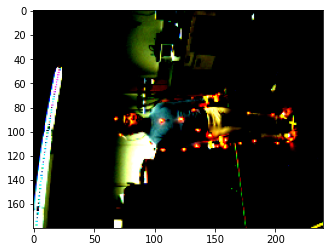

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.models import resnet101
import random
import torch.nn.functional as F

subjects = ['S01', 'S02', 'S03', 'S04', 'S05','S06', 'S07', 'S08', 'S09', 'S10', 'S11', 'S12']
actions = ['A01', 'A02', 'A03', 'A04', 'A05','A06', 'A07', 'A08', 'A09', 'A10', 'A11']
reps = ['R01', 'R02', 'R03', 'R04', 'R05']

class BerkeleyMHAD(Dataset):

    def __init__(self, vid_names, root_dir, classes, transform=None):
        self.vid_names = vid_names # list of file names for videos (ex. S01_A01_R01)
        self.root_dir = root_dir # directory where videos are stored
        self.transform = transform
        self.classes = classes
        
    def __len__(self):
        return len(self.vid_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        path = os.path.join(self.root_dir, self.vid_names[idx])
        x = np.load(path)['x']
        
        data = []
        if self.transform:
            for i in range(x.shape[0]):
                data.append(self.transform(x[i]))
        
        vid_tensor = torch.stack(data)
        label = self.classes.index(np.load(path)['y']) 
        sample = {'x': vid_tensor, 'y': label}

        return sample

class cnn_lstm(nn.Module):
    def __init__(self, classes):
        super(cnn_lstm, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 100, 3)
        self.pool1 = nn.MaxPool2d(3)
        self.n_hidden = 128
        self.n_layers = 3
        self.l_lstm = torch.nn.LSTM(input_size = 1500, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, classes)
        #self.relu = nn.LeakyReLU(.1)
        self.relu = nn.ReLU()

        self._initialize_weights()
        #self.resnet = resnet101(pretrained=True)
        #for param in self.resnet.parameters():
            #param.requires_grad = False
        #self.soft = nn.Softmax(dim = 0)

    def forward(self, x):
        batch = x.shape[0]
        #intialize lstm hidden state
        hidden_state = torch.zeros(self.n_layers, 1, self.n_hidden, requires_grad=True).to(dev)
        cell_state = torch.zeros(self.n_layers, 1, self.n_hidden).to(dev)
        #hidden_state = torch.randn(self.n_layers, 1, self.n_hidden).to(dev)
        #cell_state = torch.randn(self.n_layers, 1, self.n_hidden).to(dev)
        self.hidden = (hidden_state, cell_state)
        
        #x = self.pool1(self.relu(self.conv1(x)))
        #x = self.pool1(self.relu(self.conv2(x)))
        #x = self.pool1(self.relu(self.conv3(x)))
        #with torch.no_grad():
        #x1 = self.resnet(x)
        x1 = self.pool1(F.relu(self.conv1(x)))
        x1 = self.pool1(F.relu(self.conv2(x1)))
        x1 = self.pool1(F.relu(self.conv3(x1)))
        x1 = F.relu(self.conv4(x1))
        #print(x1.shape)
        #print(x.shape)
        x1 = x1.reshape(batch, -1).unsqueeze(0)
        #x1 = F.relu(self.fc1(x1))
        lstm_out, _ = self.l_lstm(x1, self.hidden) #lstm_out shape is batch_size, seq len, hidden state
        lstm_out = lstm_out[:,-1,:]
        lstm_out = self.relu(self.fc2(lstm_out.squeeze()))
        lstm_out = self.fc3(lstm_out)
        #print(lstm_out.shape)
        #lstm_out = self.soft(lstm_out)
        return lstm_out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                        nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                        nonlinearity='relu')
                nn.init.constant_(m.bias, 0)    

def check(i):
    #insert more i.find terms for each action
    return i.find('A01') != -1 or i.find('A02') != -1 or i.find('A05') != -1 or i.find('A07') != -1 
vid_names = [i for i in next(os.walk(data_dir))[2] if check(i)]

#vid_names = os.listdir(data_dir)
train_vid_names = [i for i in vid_names if i.find('S09') == -1 and i.find('S10') == -1 and i.find('S11') == -1 and i.find('S12') == -1]
valid_vid_names = [i for i in vid_names if i.find('S09') != -1 ]
test_vid_names = [i for i in vid_names if i.find('S10') != -1 or i.find('S11') != -1 or i.find('S12') != -1]

#data shape is (num_pics, height, width, channel)
Normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
train_dataset = BerkeleyMHAD(train_vid_names, data_dir, classes = [0, 1, 4, 6], transform=transforms.Compose([transforms.ToTensor(), Normalize]))
valid_dataset = BerkeleyMHAD(valid_vid_names, data_dir, classes = [0, 1, 4, 6], transform=transforms.Compose([transforms.ToTensor(), Normalize]))
test_dataset = BerkeleyMHAD(test_vid_names, data_dir, classes = [0, 1, 4, 6], transform=transforms.Compose([transforms.ToTensor(), Normalize]))
plt.imshow(np.transpose(train_dataset[0]['x'][0]))
print(train_dataset[0]['x'].shape)

batch_size = 1

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#change 2 to number of classes

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [ ]:
model = cnn_lstm(4).to(dev)
#model.load_state_dict(torch.load('/content/gdrive/MyDrive/lstm_checkpoints/cnn_lstm_epoch_20_state_dict.pt'))
#resnet = resnet101(pretrained=True).to(dev)
#for param in resnet.parameters():
#    param.requires_grad = False

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epoch = 20
#train
shuffled = np.arange(len(train_dataset))

train_losses = []
val_losses = []
tcorrect = 0
ttotal = 0

for t in range(epoch):
    train_loss = 0
    valid_loss = 0
    tguess = []
    tanswers = []
    tcorrect = 0
    ttotal = 0
    random.shuffle(shuffled)

    for i in range(len(train_dataset)):
        optimizer.zero_grad()

        data = train_dataset[shuffled[i]]
        inpt = data['x'].to(dev)
        label = torch.tensor(data['y']).unsqueeze(0).to(dev)
        output = model(inpt).unsqueeze(0)
        loss = criterion(output, label) #.view(-1)
        loss.backward()
        optimizer.step()  
        train_loss += loss.item()
        
        if torch.argmax(output.squeeze()) == label:
            tcorrect += 1
        ttotal += 1
    
    torch.cuda.empty_cache()   

    with torch.no_grad():
        for i in range(len(valid_dataset)):
            data = valid_dataset[i]
            inpt = data['x'].to(dev)
            label = torch.tensor(data['y']).unsqueeze(0).to(dev)
            #inpt = resnet(inpt)
            output = model(inpt).unsqueeze(0)
            loss = criterion(output, label)
            valid_loss += loss.item()
    print("epoch:", valid_loss / len(valid_dataset), train_loss / len(train_dataset))
    train_losses.append(train_loss / len(train_dataset))
    val_losses.append(valid_loss / len(valid_dataset))
    if valid_loss / len(valid_dataset) <= min(val_losses):
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/lstm_checkpoints/gru_best_state_dict.pt')
    



epoch: 1.4142863988876342 1.4324573319405318
epoch: 1.381662094593048 1.4045347798615695
epoch: 1.3934125661849976 1.3373730033636093
epoch: 1.438843587040901 1.2487257109954952
epoch: 1.2852488800883293 1.101845929119736
epoch: 1.2388637974858283 0.8423232199973427
epoch: 1.17932870388031 0.7335747314209584
epoch: 0.7335460764355958 0.505670765353716
epoch: 0.6517629604786634 0.3303128747982555
epoch: 0.9241575127001852 0.20803302611548133
epoch: 0.6370715679251588 0.12951466689319205
epoch: 0.7430198622285389 0.006868164180923486
epoch: 0.4940453487681225 0.0018490112868676078
epoch: 0.5387790406995918 0.0011603342567468645
epoch: 0.5377165327998228 0.000823987326475617
epoch: 0.5059725300539867 0.0006459256008838566
epoch: 0.47804637541994455 0.0005207259991948376
epoch: 0.4593622192987823 0.0004274388639259996
epoch: 0.4361598691626568 0.00035617087260106926
epoch: 0.421240153178951 0.0003006840742273198


In [5]:
model = cnn_lstm(4).to(dev)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/lstm_checkpoints/gru_best_state_dict.pt'))
criterion = nn.CrossEntropyLoss()

guess = []
answers = []
correct = 0
total = 0
with torch.no_grad():
    for i in range(len(test_dataset)):
        data = test_dataset[i]
        inpt = data['x'].to(dev)
        label = torch.tensor(data['y']).to(dev)
        #inpt = resnet(inpt)
        output2 = model(inpt)
        if torch.argmax(output2.squeeze()) == label:
            correct += 1
        total += 1
        answers.append(label.item())
        guess.append(output2[1].item())
#guess = torch.argmax(guess.squeeze(), dim=1)
#guess = np.array(guess).squeeze()
print("train accuracy = " + str(tcorrect / ttotal))
print("test accuracy = " + str(correct / total))
#print('CNN AUC: %.4f' % roc_auc_score(testlabel, guess), ' AUPRC: %.4f' % average_precision_score(testlabel, guess))
#torch.save(model, '/content/gdrive/MyDrive/cnn_lstm.torch')

NameError: ignored

In [6]:
print("test accuracy = " + str(correct / total))

test accuracy = 0.9411764705882353


In [29]:
from torch.autograd import Variable
class GradientAttack():
        
        """
        
        """
        
        def __init__(self, loss, epsilon):
            """
            
            """
            self.loss = loss
            self.epsilon = epsilon

        def forward(self, x, y, model, num_iter=1, alpha=0.01):
            """
            
            """
            # TODO: Implement a one step gradient attack
            # Step 1: Calculate the Loss and then calculate the
            # gradient of the Loss w.r.t the image
            y = torch.Tensor([y]).cuda()
            model.train()
            if num_iter == 1:
              alpha = self.epsilon
            # Step 2: Add the gradient (or its sign for each pixel),
            # multiplied by a small step size, to 
            # the original image
            # you might need to clamp the modified image to 
            # make sure the values of each pixel are between [0,1]
            x_adv = x
            for iteration in range(num_iter):
                x_adv = x_adv.cuda()
                x_adv = Variable(x_adv, requires_grad=True)
                # Step 1: Calculate the Loss and then calculate the
                # gradient of the Loss w.r.t the image
                loss_adv = self.loss(model(x_adv).unsqueeze(0), y.long())
                loss_adv.backward(retain_graph=True)
                #print(x_adv.grad)
                with torch.no_grad():
                    # Step 2: Add the gradient (or its sign for each pixel),
                    # multiplied by a small step size, to the original image                   
                    # You might need to clamp the modified image to 
                    # make sure the values of each pixel are between [0,1]    
                    x_adv = x + torch.clamp(x_adv + torch.sign(x_adv.grad) * alpha - x, -self.epsilon, self.epsilon)
    
            
            x_adv = torch.clamp(x_adv, 0, 1)
            return x_adv

In [31]:
class HAttack():
        
        """
        
        """
        
        def __init__(self, loss_function, epsilon):
            """
            
            """
            self.loss_function = loss_function
            self.epsilon = epsilon

        def forward(self, x, y, model, num_iter=1, pmp_iter = 1, alpha=0.01, inner_alpha=1):
            """
            
            """       
            if num_iter == 1:
              alpha = self.epsilon
            # TODO: Implement a one step gradient attack
            # Step 1: Calculate the Loss and then calculate the
            # gradient of the Loss w.r.t the image
            y = torch.Tensor([y]).cuda()
            model.train()
            # Step 2: Add the gradient (or its sign for each pixel),
            # multiplied by a small step size, to 
            # the original image
            # you might need to clamp the modified image to 
            # make sure the values of each pixel are between [0,1]
            x_adv = x
            for iteration in range(num_iter):
                x_adv = x_adv.cuda()
                x_adv = Variable(x_adv, requires_grad=True)

                step = torch.zeros(x.shape, requires_grad=True).to(dev)
                step = Variable(x_adv, requires_grad=True)               
                for k in range(pmp_iter):
                  # Step 1: Calculate the Loss and then calculate the
                  # gradient of the Loss w.r.t the image
                  #step = torch.zeros(x.shape, requires_grad=True).to(dev)
                  #step = Variable(x_adv, requires_grad=True)
                  loss_adv = self.loss_function(model(x_adv + step).unsqueeze(0), y.long())
                  loss_adv.backward(retain_graph=True) 
                      # Step 2: Add the gradient (or its sign for each pixel),
                      # multiplied by a small step size, to the original image                   
                      # You might need to clamp the modified image to
                  #print(x.grad, step.grad)                      
                  with torch.no_grad():
                    step += torch.sign(step.grad) * inner_alpha #if want to be = to PGD at pmp_iter = 1, then need to be inner_alpha = 1
                x_adv = x + torch.clamp(x_adv + step - x, -self.epsilon, self.epsilon)
                #x_adv = x + torch.clamp(x_adv + torch.sign(x_adv.grad) * alpha - x, -self.epsilon, self.epsilon)

              # make sure the values of each pixel are between [0,1]
            x_adv = torch.clamp(x_adv, 0, 1)
            return x_adv    

In [ ]:
model = cnn_lstm(4).to(dev)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/lstm_checkpoints/gru_best_state_dict.pt'))

#resnet = resnet101(pretrained=True).to(dev)
#for param in resnet.parameters():
#    param.requires_grad = False

loss = nn.CrossEntropyLoss()
adv_attack = GradientAttack(loss, 0.1)    

In [12]:
#plt.imshow(np.rot90(np.transpose(inpt[0].cpu().detach().numpy()), k=3))

In [13]:
#plt.imshow(np.rot90(np.transpose(inpt3[0].cpu().detach().numpy()), k=3))

## Results for Fast Gradient Sign Method

In [ ]:
################ Model Accuracy On Train Dataset Post Training #################
accurates = 0
for data in train_dataloader:
  torch.cuda.empty_cache()   
  input = data['x'][0].to(dev)
  label = torch.tensor(data['y']).unsqueeze(0).to(dev)
  input.requires_grad = True
  input = adv_attack.forward(input, label, model, num_iter=1)
  model.eval()
  out = model(input)
  if torch.argmax(out).item() == label:
    accurates += 1

accuracy = accurates / len(train_dataloader)
print('The model accuracy on the train dataset after training is ' + str(accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


The model accuracy on the train dataset after training is 0.61875


In [ ]:
################ Model Accuracy On Validation Dataset Post Training #################
accurates = 0
for data in valid_dataloader:
  torch.cuda.empty_cache()   
  input = data['x'][0].to(dev)
  label = torch.tensor(data['y']).unsqueeze(0).to(dev)
  input.requires_grad = True
  input = adv_attack.forward(input, label, model, num_iter=1)
  model.eval()
  out = model(input)
  if torch.argmax(out).item() == label:
    accurates += 1

accuracy = accurates / len(valid_dataloader)
print('The model accuracy on the validation dataset after training is ' + str(accuracy))
    
accurates = 0
for data in test_dataloader:
  torch.cuda.empty_cache()   
  input = data['x'][0].to(dev)
  label = torch.tensor(data['y']).unsqueeze(0).to(dev)
  input.requires_grad = True
  input = adv_attack.forward(input, label, model, num_iter=1)
  model.eval()
  out = model(input)
  if torch.argmax(out).item() == label:
    accurates += 1

accuracy = accurates / len(test_dataloader)
print('The model accuracy on the testing dataset after training is ' + str(accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


The model accuracy on the validation dataset after training is 0.35


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


The model accuracy on the testing dataset after training is 0.43137254901960786


In [ ]:
np.arange(0, 1, 0.05)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [ ]:
epsilon_range = np.arange(0, 1, 0.5)
accs = []
loss = nn.CrossEntropyLoss()

for epsilon in epsilon_range:
  accurates = 0
  adv_attack = GradientAttack(loss, epsilon) 
  for data in test_dataloader:
    torch.cuda.empty_cache()   
    input = data['x'][0].to(dev)
    label = torch.tensor(data['y']).unsqueeze(0).to(dev)
    input.requires_grad = True
    input = adv_attack.forward(input, label, model, num_iter=1)
    model.eval()
    out = model(input)
    if torch.argmax(out).item() == label:
      accurates += 1

  accs.append(accurates / len(test_dataloader))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'Epsilon vs. Accuracy for FGSM')

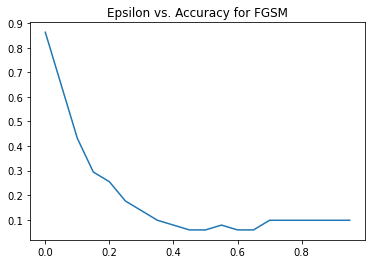

In [ ]:
plt.plot(epsilon_range, accs)
plt.title("Epsilon vs. Accuracy for FGSM")

## Results for PGD

In [30]:
iteration_range = np.arange(2, 51, 2)
accs = []
accs2 = []
loss = nn.CrossEntropyLoss()

for iteration in iteration_range:
  accurates = 0
  accurates2 = 0
  adv_attack = GradientAttack(loss, 0.1)
  adv_attack2 = HAttack(loss, 0.1)
  for data in test_dataloader:
    torch.cuda.empty_cache()   
    input = data['x'][0].to(dev)
    label = torch.tensor(data['y']).unsqueeze(0).to(dev)
    input.requires_grad = True
    input = adv_attack.forward(input, label, model, num_iter=iteration)
    model.eval()
    out = model(input)
    if torch.argmax(out).item() == label:
      accurates += 1
  '''
    input = data['x'][0].to(dev)
    label = torch.tensor(data['y']).unsqueeze(0).to(dev)
    input.requires_grad = True
    input = adv_attack2.forward(input, label, model, num_iter=iteration, pmp_iter=5)
    model.eval()
    out = model(input)
    if torch.argmax(out).item() == label:
      accurates2 += 1
  accs2.append(accurates2 / len(test_dataloader))
  print(accurates2 / len(test_dataloader))'''
  accs.append(accurates / len(test_dataloader))
  print(accurates / len(test_dataloader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


0.8431372549019608
0.7647058823529411
0.6862745098039216
0.6470588235294118


KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Iteration vs. Accuracy for PGM')

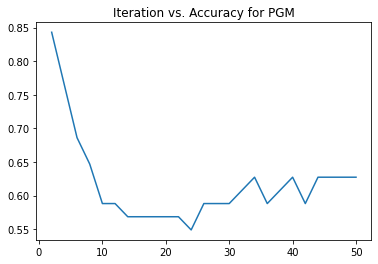

In [ ]:
plt.plot(iteration_range, accs, label='PGM')
plt.plot(iteration_range, accs2, label='Novel')
plt.title("Iteration vs. Accuracy for Attacks")
plt.legend()

In [32]:
iteration_range = np.arange(2, 51, 2)
accs2 = []
loss = nn.CrossEntropyLoss()

for iteration in iteration_range:
  accurates2 = 0
  adv_attack2 = HAttack(loss, 0.1)
  for data in test_dataloader:
    torch.cuda.empty_cache()   
    input = data['x'][0].to(dev)
    label = torch.tensor(data['y']).unsqueeze(0).to(dev)
    input.requires_grad = True
    input = adv_attack2.forward(input, label, model, num_iter=iteration, pmp_iter=5)
    model.eval()
    out = model(input)
    if torch.argmax(out).item() == label:
      accurates2 += 1
  accs2.append(accurates2 / len(test_dataloader))
  print(accurates2 / len(test_dataloader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


0.17647058823529413
0.17647058823529413


KeyboardInterrupt: ignored

In [ ]:
plt.plot(iteration_range, accs2, label='Novel')
plt.title("Iteration vs. Accuracy for Attacks")
plt.legend()